# **New Zealand flood study - model analysis**

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *
from wwa_nonstationary_fitting import *

---
# **CORDEX**

Data downloaded via synda
```
for fnm in sorted(glob.glob("../synda/data/CORDEX/AUS-*/*/*/*/day/pr"):
    
    mdl_fl = sorted(glob.glob(fnm+"/*.nc"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+mdl_fl[0][-20:-12]+"-", mdl_fl[-1].split("/")[-1])
    print(new_fnm)
    
    # skip if file already exists
    if len(glob.glob(new_fnm)) > 0: continue
    
    # also skip if not both historical & RCP runs available
    if not all([any([s in fnm for fnm in mdl_fl]) for s in ["historical", "rcp85"]]): continue
    
    # otherwise - carry on
    rcp = xr.open_mfdataset([fnm for fnm in mdl_fl if "rcp85" in fnm])
    hist = xr.open_mfdataset([fnm for fnm in mdl_fl if "historical" in fnm])
    
    if "rlon" in rcp.dims:
        hist = hist.assign_coords(rlon = rcp.rlon, rlat = rcp.rlat)
    elif "x" in rcp.dims:
        hist = hist.assign_coords(x = rcp.x, y = rcp.y)
    else:
        print(hist.dims)
        continue
        
    da = xr.concat([hist, rcp], "time")
    
    nz_mask = np.logical_and(np.logical_and(da.lat > -42, da.lat < -34), np.logical_and(da.lon > 172, da.lon < 179))
    
    if "rlon" in rcp.dims:
        nz_mask = nz_mask.where(nz_mask == 1).dropna("rlon", "all").dropna("rlat", "all")
        da = da.sel(rlon = nz_mask.rlon, rlat = nz_mask.rlat)
    elif "x" in rcp.dims:
        nz_mask = nz_mask.where(nz_mask == 1).dropna("x", "all").dropna("y", "all")
        da = da.sel(x = nz_mask.x, y = nz_mask.y)
    
    da.to_netcdf(new_fnm)
```

## **rx2day spatial pattern**

In [24]:
fl = sorted(glob.glob("data/pr_AUS-*.nc"))
mswep = xr.open_dataset("data/mswep_rx2day.nc").rx2day.mean("time")

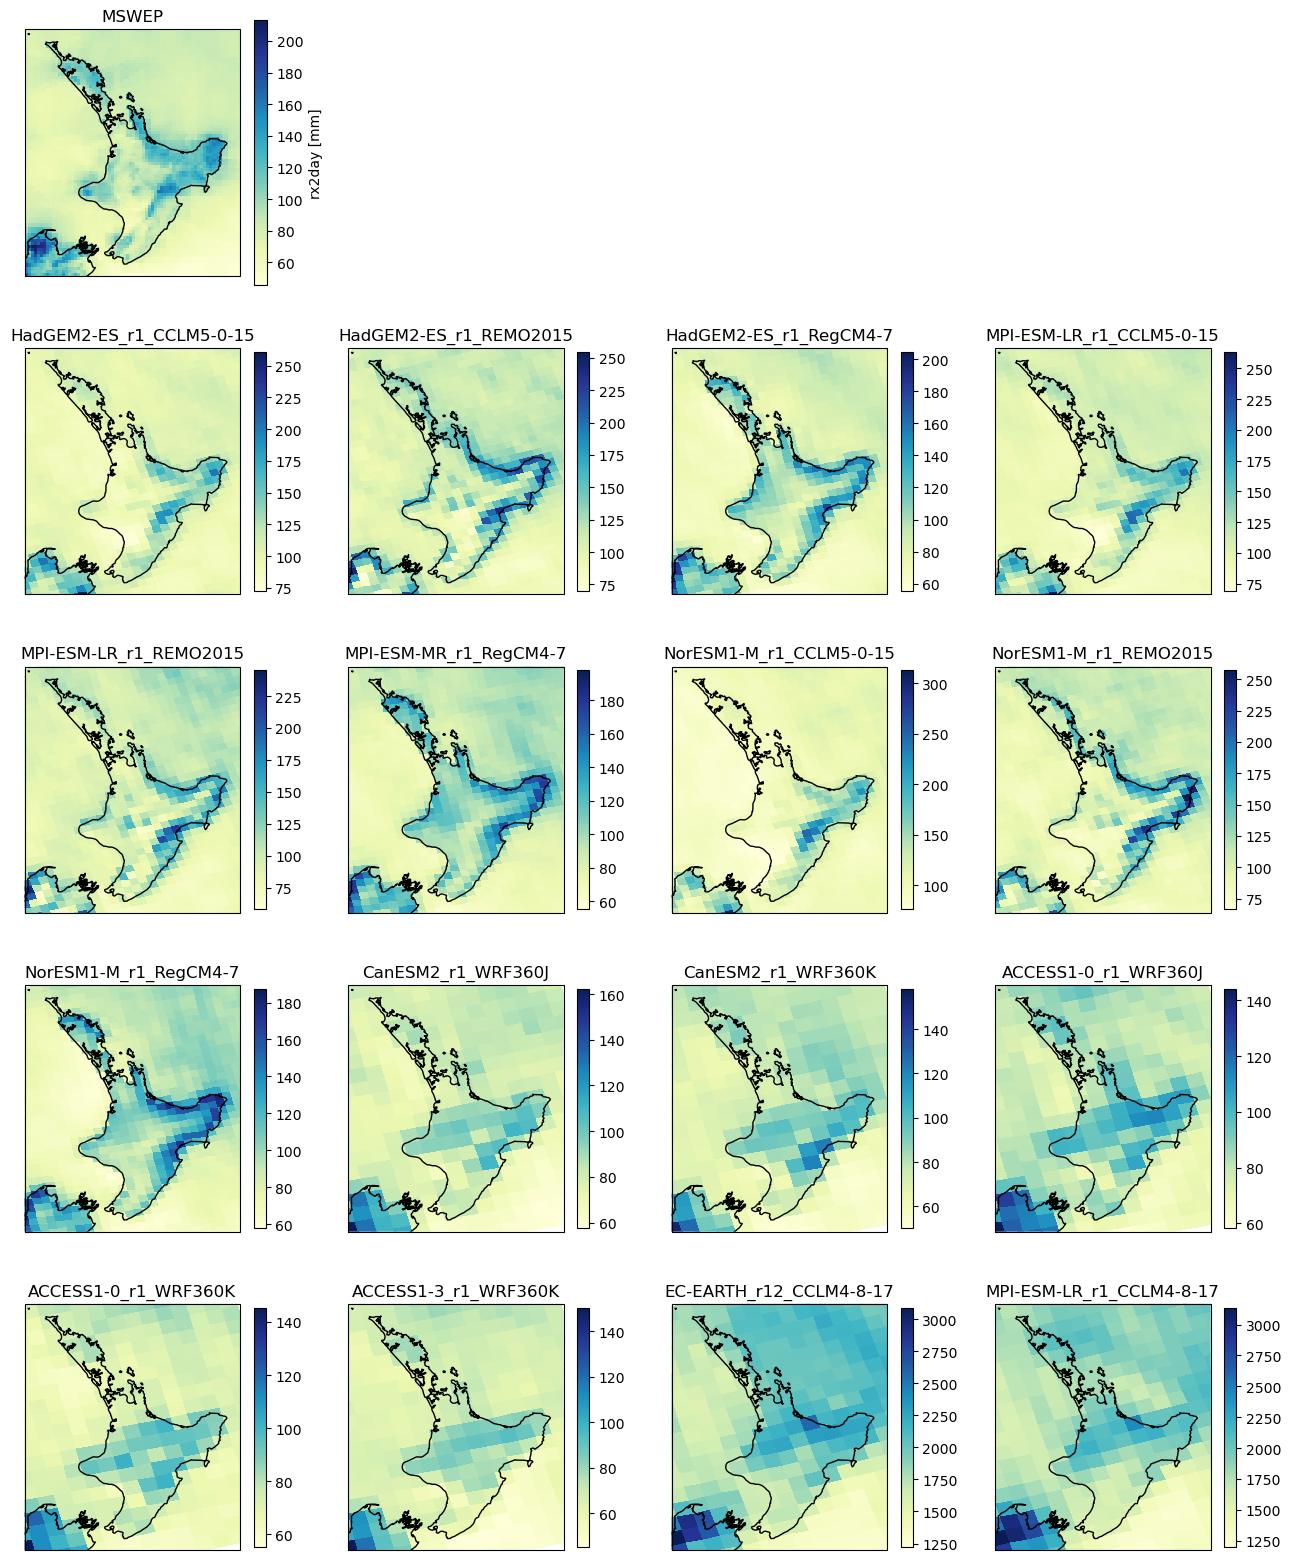

In [43]:
# AUS-22 ok, AUS-44 terrible.
fig, axs = plt.subplots(ncols = 4, nrows = 5, figsize = (16,20), dpi = 100,
                        subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (172,179,-42,-34)})
plot_kws = {"cmap" : "YlGnBu"}

# MSWEP reference pattern
mswep.plot(ax = axs[0,0], **plot_kws)
axs[0,0].coastlines()
axs[0,0].set_title("MSWEP")

# turn off remaining axes
for ax in axs[0,1:]: ax.set_axis_off()

# plot individual 
for i in range(len(fl)):
    
    fnm = fl[i]
    rx2day = convert_units_to(xr.open_dataset(fnm).pr, "mm/day").rolling(time = 2).sum().resample(time = "AS-JUL").max()
    rx2day = rx2day.sel(time = slice("1979", "2023")).mean("time")
    
    ax = fig.axes[i+4]
    cbar = ax.pcolormesh(rx2day.lon, rx2day.lat, rx2day, **plot_kws)
    ax.set_title(cordex_model(fnm))
    plt.colorbar(cbar, ax = ax, shrink = 0.9)
    
    ax.coastlines()
    
plt.savefig("cordex_spatial-patterns.png")

## **Time series for climate explorer**

In [52]:
# compute rx2day for all 0.22-resolution models (excluding AUS-44 on basis of spatial plots)
# for fnm in sorted(glob.glob("data/pr_AUS-22_*.nc")):
#     convert_units_to(xr.open_dataset(fnm).pr, "mm/day").rolling(time = 2).sum().resample(time = "AS-JUL").max().rename("rx2day").to_netcdf(re.sub("pr", "rx2day", fnm))

In [178]:
hg = gpd.read_file("sf_hawkes-gisborne/")
for fnm in sorted(glob.glob("data/rx2day_AUS-22_*.nc")):
        
    mdl = cordex_model(fnm)
    csv_fnm = "ts/NZ-flood_rx2day_AUS-22_"+mdl+".dat"
        
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+"_".join(fnm.split("_")[1:7])+" rx2day New Zealand flooding 2023, c.barnes22@imperial.ac.uk"
    str2 = "# rx2day [mm] 2-day accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year rx2day"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get average precip over region of interest, accumulate over two days, get annual maximum
    rx2day = xr.open_dataset(fnm).rx2day
    rx2day = rx2day.where(regionmask.mask_3D_geopandas(hg, rx2day.lon, rx2day.lat) == 1).mean([d for d in rx2day.dims if not d == "time"]).squeeze(drop = True)
    rx2day = rx2day.assign_coords(time = rx2day.time.dt.year)

    rx2day.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [177]:
for fnm in glob.glob("data/rx2day_AUS-22_*.nc"):
    
    gcm = cordex_model(fnm).split("_")[0]
    csv_fnm = "ts/NZ-flood_gsat_"+gcm+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+gcm+" gsat New Zealand flooding 2023, c.barnes22@imperial.ac.uk"
    str2 = "# gsat [degC] smoothed global mean surface air temperature at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year gsat"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    df = pd.read_csv("../00_gsat/cordex_tas_Amon_"+gcm+"_rcp85_r1i1p1.dat", comment = "#", header = None, sep = " ", names = ["year", "gsat"], index_col = "year")
    df.to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **List of models to run from climate explorer**

In [194]:
# string of model/GSAT pairs to pass to cx-attribution-wrapper.sh
" ".join(["p_"+re.sub(".dat", "", fnm.split("/")[-1])+":"+"t_NZ-flood_gsat_"+fnm.split("_")[3] for fnm in glob.glob("ts/*rx2day_AUS-22*")])

'p_NZ-flood_rx2day_AUS-22_HadGEM2-ES_r1_RegCM4-7:t_NZ-flood_gsat_HadGEM2-ES p_NZ-flood_rx2day_AUS-22_NorESM1-M_r1_RegCM4-7:t_NZ-flood_gsat_NorESM1-M p_NZ-flood_rx2day_AUS-22_NorESM1-M_r1_REMO2015:t_NZ-flood_gsat_NorESM1-M p_NZ-flood_rx2day_AUS-22_HadGEM2-ES_r1_REMO2015:t_NZ-flood_gsat_HadGEM2-ES p_NZ-flood_rx2day_AUS-22_MPI-ESM-LR_r1_REMO2015:t_NZ-flood_gsat_MPI-ESM-LR p_NZ-flood_rx2day_AUS-22_NorESM1-M_r1_CCLM5-0-15:t_NZ-flood_gsat_NorESM1-M p_NZ-flood_rx2day_AUS-22_MPI-ESM-LR_r1_CCLM5-0-15:t_NZ-flood_gsat_MPI-ESM-LR p_NZ-flood_rx2day_AUS-22_HadGEM2-ES_r1_CCLM5-0-15:t_NZ-flood_gsat_HadGEM2-ES p_NZ-flood_rx2day_AUS-22_MPI-ESM-MR_r1_RegCM4-7:t_NZ-flood_gsat_MPI-ESM-MR'

In [ ]:
# ! bash cx-attribution-wrapper.sh
print("Done.")

In [204]:
pd.read_csv("cx-results_cordex.txt", skiprows = 1, sep = " ", index_col = 0).to_csv("cx-cordex.csv")

## **Maps of fitted trend in rx2day**

In [103]:
regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())[:9]
for fnm in glob.glob("data/rx2day_AUS-22_*.nc"):
    
    rx2day = xr.open_dataset(fnm).rx2day
    rx2day = rx2day.assign_coords(time = rx2day.time.dt.year).sel(time = slice(None, 2023))
    lsm = regionmask.mask_3D_geopandas(regions, rx2day.lon, rx2day.lat).sum("region")
    
    gmst = pd.read_csv("../00_gsat/cordex_tas_Amon_"+cordex_model(fnm).split("_")[0]+"_rcp85_r1i1p1.dat",
                       comment = "#", header = None, sep = " ", names = ["year", "gsat"], index_col = "year").to_xarray().sel(year = rx2day.time).gsat
    
    ns_mapfit(gev, "fixeddisp", rx2day.where(lsm == 1), gmst).to_netcdf(re.sub("data", "fitted_models", fnm))

In [104]:
mswep_fitted = xr.open_dataset("fitted_models/mswep_rx2day_fitted-gev-fixeddisp.nc")

In [128]:
plot_kwargs = {"nll" : {"cmap" : "viridis"},
               "mu" : {"cmap" : "YlGnBu"},
               "sigma" : {"cmap" : "YlGnBu"},
               "alpha" : {"cmap" : "RdBu", "vmin" : -30, "vmax" : 30},
               "shape" : {"cmap" : "PuOr", "vmin" : -0.5, "vmax" : 0.5}}

for fnm in glob.glob("fitted_models/rx2day_AUS-22_*.nc"):
    
    fitted = xr.open_dataset(fnm)
    
    fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize = (20,4), dpi = 100, sharey = False, 
                            subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (172,179,-42,-34)})
    
    for i in range(5):
        par = fitted.pars.values[i+1]
        cbar = axs[i].pcolormesh(fitted.lon, fitted.lat, fitted.ml_fit.sel(pars = par), **plot_kwargs[par])
        plt.colorbar(cbar, ax = axs[i], location = "bottom", shrink = 0.9, fraction = 0.03, pad = 0.04)
        axs[i].set_title(par)
        axs[i].coastlines(color = "k")
        regions.boundary.plot(ax = axs[i], color = "k", lw = 1, ls = "--", alpha = 0.2)
        
    plt.suptitle("Fitted model parameters for "+cordex_model(fnm.split("/")[-1])+"(-2023)")
    
    plt.savefig(re.sub("nc", "png", re.sub("rx2day", "pars_rx2day", fnm))); plt.close()